<a href="https://colab.research.google.com/github/zeligism/ScaledVR/blob/main/Scaled_VR_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import sklearn
import scipy
import time
from numba import njit
from sklearn.preprocessing import normalize
SEED = 123
np.random.seed(SEED)

# Load data
data source: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/

In [2]:
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a1a

--2022-01-19 19:05:07--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a1a
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114818 (112K)
Saving to: ‘a1a’

a1a                 100%[===================>] 112.13K   200KB/s    in 0.6s    

2022-01-19 19:05:09 (200 KB/s) - ‘a1a’ saved [114818/114818]



In [3]:
!head a1a

-1 3:1 11:1 14:1 19:1 39:1 42:1 55:1 64:1 67:1 73:1 75:1 76:1 80:1 83:1 
-1 3:1 6:1 17:1 27:1 35:1 40:1 57:1 63:1 69:1 73:1 74:1 76:1 81:1 103:1 
-1 4:1 6:1 15:1 21:1 35:1 40:1 57:1 63:1 67:1 73:1 74:1 77:1 80:1 83:1 
-1 5:1 6:1 15:1 22:1 36:1 41:1 47:1 66:1 67:1 72:1 74:1 76:1 80:1 83:1 
-1 2:1 6:1 16:1 22:1 36:1 40:1 54:1 63:1 67:1 73:1 75:1 76:1 80:1 83:1 
-1 2:1 6:1 14:1 20:1 37:1 41:1 47:1 64:1 67:1 73:1 74:1 76:1 82:1 83:1 
-1 1:1 6:1 14:1 22:1 36:1 42:1 49:1 64:1 67:1 72:1 74:1 77:1 80:1 83:1 
-1 1:1 6:1 17:1 19:1 39:1 42:1 53:1 64:1 67:1 73:1 74:1 76:1 80:1 83:1 
-1 2:1 6:1 18:1 20:1 37:1 42:1 48:1 64:1 71:1 73:1 74:1 76:1 81:1 83:1 
+1 5:1 11:1 15:1 32:1 39:1 40:1 52:1 63:1 67:1 73:1 74:1 76:1 78:1 83:1 


In [4]:
# see  https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html
from joblib import Memory
from sklearn.datasets import load_svmlight_file
mem = Memory("./mycache")

@mem.cache
def get_data(filePath):
    data = load_svmlight_file(filePath)
    return data[0], data[1]

X, y = get_data("a1a")
n, d =X.shape
X = normalize(X, norm='l2', axis=1)
print("We have %d samples, each has up to %d features"%(n,d))

________________________________________________________________________________
[Memory] Calling __main__--content-<ipython-input-c47fa7ee0e78>.get_data...
get_data('a1a')
_________________________________________________________get_data - 0.0s, 0.0min
We have 1605 samples, each has up to 119 features


# Logistic Loss
$n=$ number of data points

$d=$ feature dimension

$X \in \mathbb{R}^{n \times d}$, $x_i = X[i,:] \in \mathbb{R}^{d}$, $y \in \mathbb{R}^{n}$, and $w \in \mathbb{R}^{d}$.

Then,

$
F(w) = \frac1n \sum_{i=1}^n \log(1+e^{-y_i x_i^T w})
$

$
\nabla F(w) = \frac1n \sum_{i=1}^n 
\frac{\exp(-y_i x_i^T w)}{(1+\exp(-y_i x_i^T w))} (-y_i x_i)
$

$
\nabla^2 F(w) = \frac1n \sum_{i=1}^n 
\left(
  \frac{\exp(-y_i x_i^T w)}
       {(1+\exp(-y_i x_i^T w))^2}
\right) (  x_i x_i^T )
$

In [36]:
@njit
def logistic_loss_jit(X,y,w):
  ...

@njit
def logistic_loss_grad_jit(X,y,w):
  ...

def logistic_loss(X,y,w):
  t = -y * (X @ w)
  loss = np.mean(np.log(1 + np.exp(t)))
  return loss

def logistic_loss_grad(X,y,w):
  t = -y * (X @ w)
  r = t*0.0
  ep = np.exp(t[t < 0])
  en = np.exp(-t[t >= 0])
  r[t <  0] = ep / (1 + ep)
  r[t >= 0] = 1 / (1 + en)
  grad = X.T.dot(-y * r) / X.shape[0]
  return grad

def logistic_loss_hessian(X,y,w):
  t = -y * (X @ w)
  r = t*0.0
  ep = np.exp(t[t < 0])
  en = np.exp(-t[t >= 0])
  r[t <  0] = ep / (1 + ep)**2
  r[t >= 0] = en / (1 + en)**2
  hessian = X.T.dot(r.reshape(-1,1) * X) / X.shape[0]
  return hessian

def F(X, y, w, i=None):
  if i is not None:
    if isinstance(i, int):
      i = [i]
    y = y[i]
    X = X[i,:]
  return logistic_loss(X,y,w)

def grad(X, y, w, i=None):
  if i is not None:
    if isinstance(i, int):
      i = [i]
    y = y[i]
    X = X[i,:]
  return logistic_loss_grad(X,y,w)

def hessian(X, y, w, i=None):
  if i is not None:
    if isinstance(i, int):
      i = [i]
    y = y[i]
    X = X[i,:]
  X = np.array(X.todense()) # for element-wise prod
  return logistic_loss_hessian(X,y,w)

In [37]:
def test_logistic(X,y):
  import torch
  # np
  i = np.random.choice(X.shape[0], 10)
  w = np.random.randn(X.shape[1])
  X = X[i]
  y = y[i]
  L = F(X,y,w)
  G = grad(X,y,w)
  H = hessian(X,y,w)
  # torch
  def F_torch(w):
    return torch.mean(torch.log(1 + torch.exp(-y * (X @ w))))
  w = torch.Tensor(w).requires_grad_()
  X = torch.Tensor(X.todense()).requires_grad_()
  y = torch.Tensor(y)
  L_torch = F_torch(w)
  G_torch, = torch.autograd.grad(L_torch, w)
  H_torch = torch.autograd.functional.hessian(F_torch, w)
  # check
  print(L.sum(), L_torch.sum().item())
  assert np.abs(L.sum() - L_torch.sum().item()) < 0.0001
  print(G.sum(), G_torch.sum().item())
  assert np.abs(G.sum() - G_torch.sum().item()) < 0.0001
  print(H.sum(), H_torch.sum().item())
  assert np.abs(H.sum() - H_torch.sum().item()) < 0.0001

test_logistic(X,y)
print("Success!")

0.8350229686068997 0.8350229263305664
1.691001408972953 1.6910014152526855
3.1689606180670107 3.1689605712890625
Success!


# Plot

In [38]:
def plot_data(data, fname=None):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  fig.set_size_inches(20, 6)
  
  ax1.plot(data[:,0])
  ax1.set_ylabel(r"$F(w_t)$")
  ax1.set_xlabel(r"iteration $t$")  
  
  ax2.semilogy(data[:,1])
  ax2.set_ylabel(r"$||\nabla F(w_t)||^2$")
  ax2.set_xlabel(r"iteration $t$") 
  
  ax3.plot(data[:,2])
  ax3.set_ylabel(r"error")
  ax3.set_xlabel(r"iteration $t$") 

  if fname is not None:
    plt.savefig(fname)

# SGD

In [39]:
def SGD(X, y, gamma=0.02, BS=1, T=10000, seed=SEED):
  np.random.seed(seed+1)
  data = []
  w = np.zeros(X.shape[1])
  for it in range(T):
    i = np.random.choice(X.shape[0], BS)
    w = w - gamma * grad(X,y,w,i)
    data.append((F(X,y,w),
                  np.linalg.norm(grad(X,y,w))**2,
                  np.mean(X.dot(w)*y < 0)))
  return w, np.array(data)

CPU times: user 8.48 s, sys: 8.42 ms, total: 8.49 s
Wall time: 8.49 s


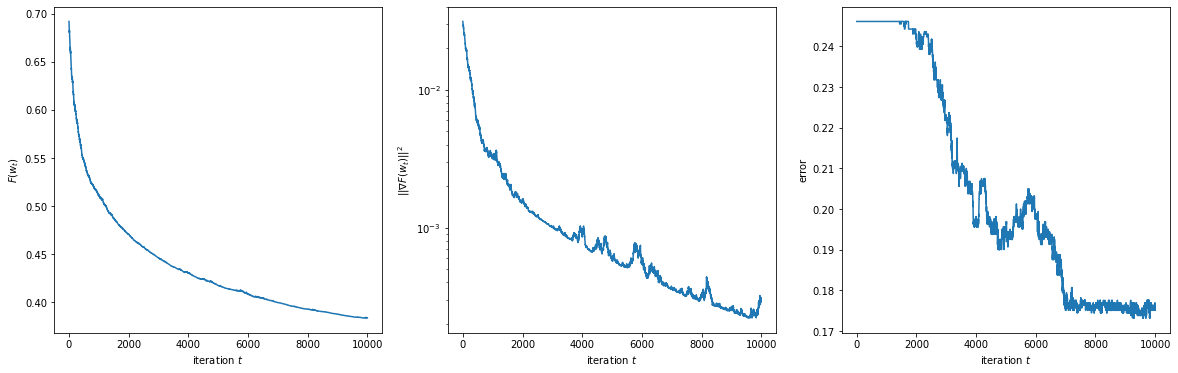

In [40]:
%%time
_, data = SGD(X,y)
plot_data(data)

using a bigger batch size
CPU times: user 8.45 s, sys: 5.23 ms, total: 8.46 s
Wall time: 8.46 s


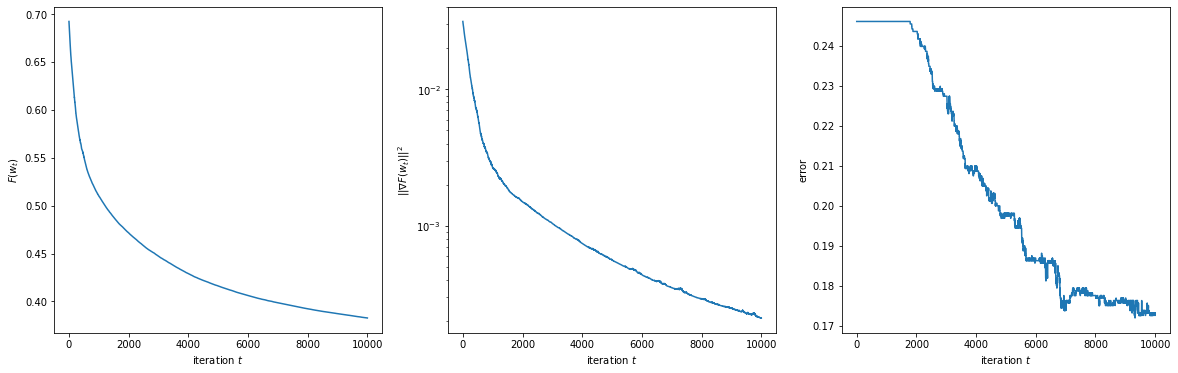

In [41]:
%%time
print("using a bigger batch size")
_, data = SGD(X,y,BS=10)
plot_data(data)

## Use bad scaling and run SGD again

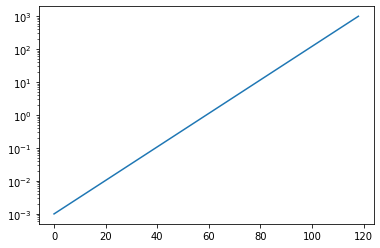

In [42]:
BAD_SCALE = 10**np.linspace(-3,3,X.shape[1])
#BAD_SCALE = 10**np.linspace(-3,5,X.shape[1])**3
plt.semilogy(BAD_SCALE)

def corrupt_scale(X, bad_scale=BAD_SCALE, seed=SEED):
  np.random.seed(seed+1)
  np.random.shuffle(bad_scale)
  X_bad = X[:]
  X_bad = X.multiply(bad_scale.reshape(1,-1)).tocsr()
  # X_bad = normalize(X_bad, norm='l2', axis=1)
  return X_bad

X_bad = corrupt_scale(X)

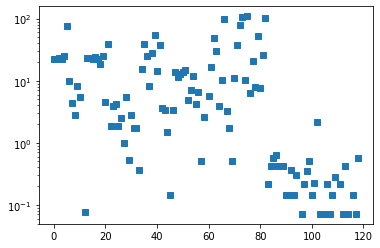

In [43]:
plt.semilogy([np.linalg.norm(X[:,j].data)**2 for j in range(d)],'s')

use uneven scaling of features
CPU times: user 8.38 s, sys: 12.8 ms, total: 8.39 s
Wall time: 8.39 s


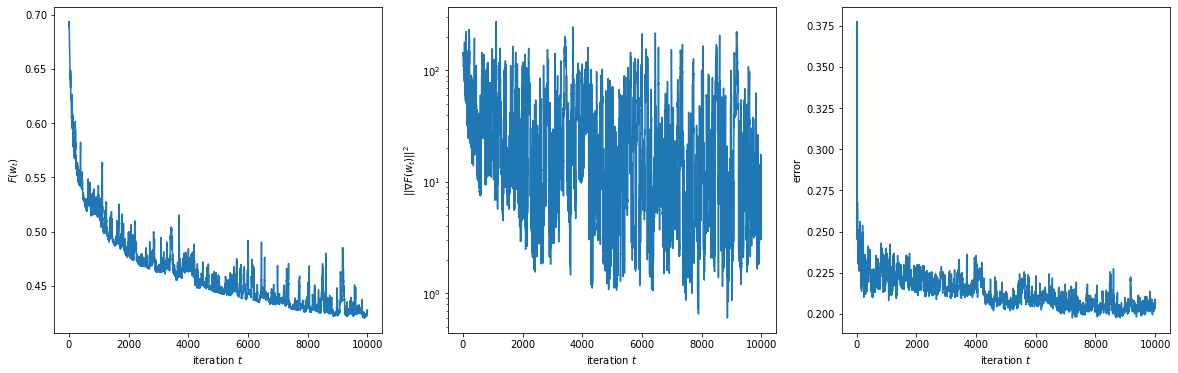

In [44]:
%%time
print("use uneven scaling of features")
_, data = SGD(X_bad,y,gamma=1e-5)
plot_data(data)

try with a bigger batch size
CPU times: user 8.65 s, sys: 22.6 ms, total: 8.67 s
Wall time: 8.69 s


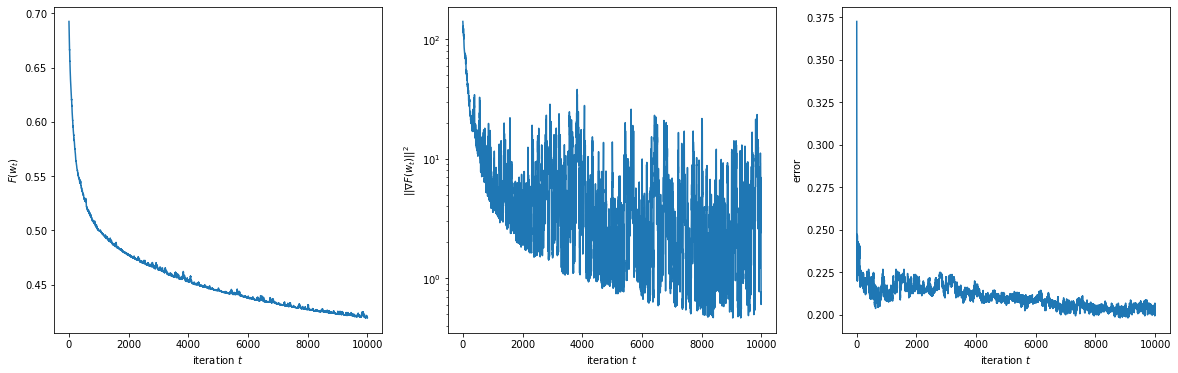

In [45]:
%%time
print("try with a bigger batch size")
_, data = SGD(X_bad,y,BS=10,gamma=1e-5)
plot_data(data)

# SARAH

In [103]:
def SARAH(X, y, gamma=0.2, BS=1, epochs=10, seed=SEED):
  np.random.seed(seed+1)
  data = []
  wn = np.zeros(X.shape[1])
  for ep in range(epochs):
    v = grad(X,y,wn)
    nv0 = np.linalg.norm(v)
    wp = wn[:]
    for it in range(10**10):
      i = np.random.choice(X.shape[0], BS)
      gn = grad(X,y,wn,i)
      gp = grad(X,y,wp,i)
      v += gn - gp
      wp = wn[:]
      wn = wn - gamma * v
      data.append((F(X,y,wn),
                   np.linalg.norm(grad(X,y,wn))**2,
                   np.mean(X.dot(wn)*y < 0)))
      nv = np.linalg.norm(v)
      if nv < 0.1*nv0 or it > X.shape[0]:
        break
        
  return wn, np.array(data)

CPU times: user 17.5 s, sys: 47.4 ms, total: 17.6 s
Wall time: 17.6 s


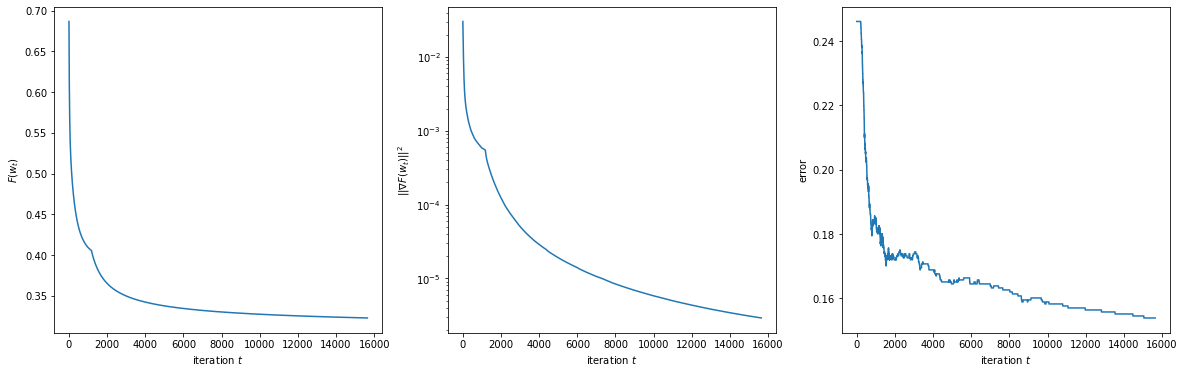

In [104]:
%%time
_, data = SARAH(X,y)
plot_data(data)

with a bigger batch size
CPU times: user 16.9 s, sys: 43.2 ms, total: 17 s
Wall time: 17 s


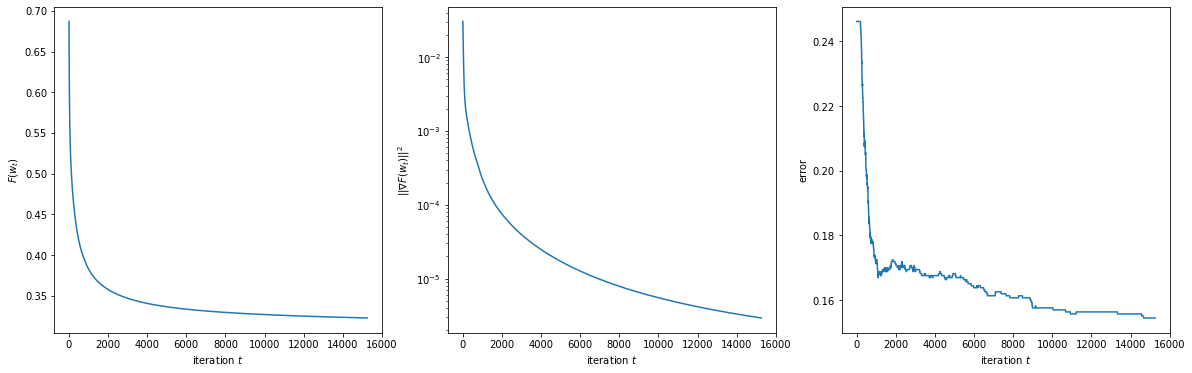

In [105]:
%%time
print("with a bigger batch size")
_, data = SARAH(X,y,BS=10)
plot_data(data)

## Use bad scaling and run SARAH again

use uneven scaling of features
CPU times: user 34.8 s, sys: 88.9 ms, total: 34.9 s
Wall time: 34.9 s


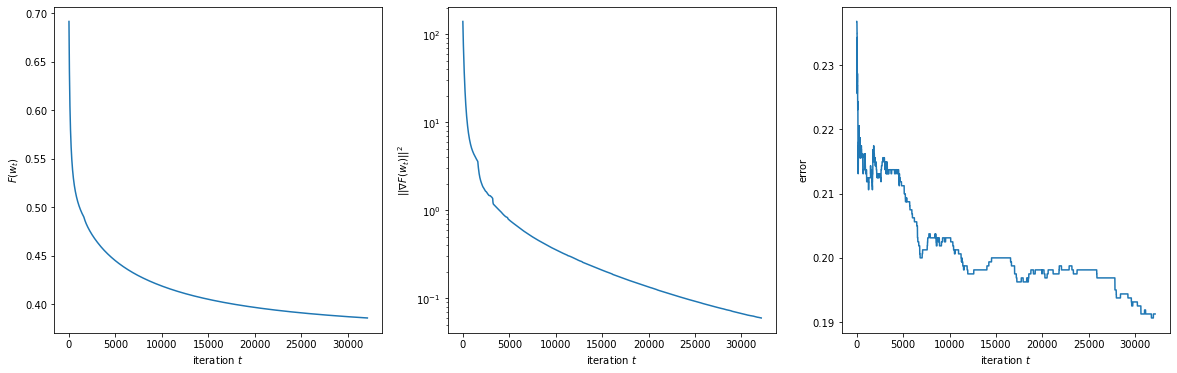

In [67]:
%%time
print("use uneven scaling of features")
_, data = SARAH(X_bad,y,gamma=1e-5,epochs=20)
plot_data(data)

with a bigger batch size
CPU times: user 35.7 s, sys: 111 ms, total: 35.8 s
Wall time: 35.7 s


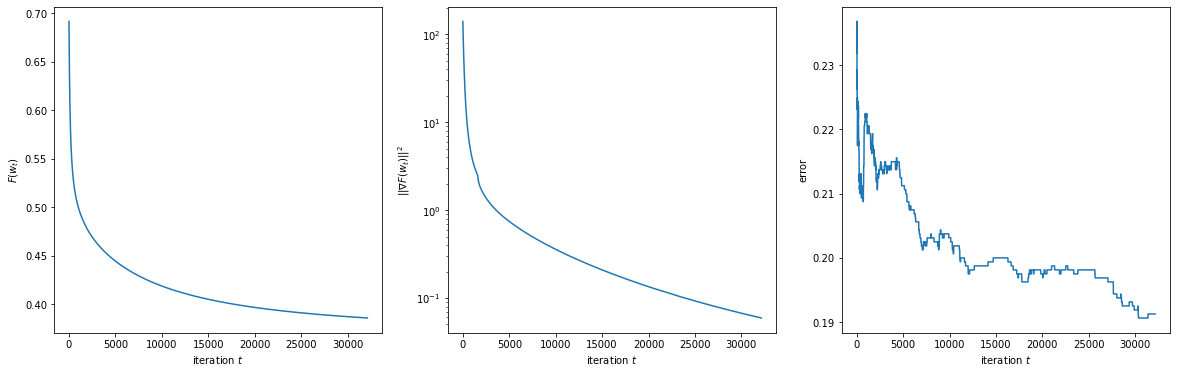

In [68]:
%%time
print("with a bigger batch size")
_, data = SARAH(X_bad,y,BS=10,gamma=1e-5,epochs=20)
plot_data(data)

# Hessian scaling

## Check approximation of Hessian diagonal

In [69]:
w = np.random.randn(X.shape[1])
H = hessian(X,y,w)
diag_H = np.diagonal(H)
H_bad = hessian(X_bad,y,w)
diag_H_bad = np.diagonal(H_bad)

0.20598513937002777
0.1789464670918542


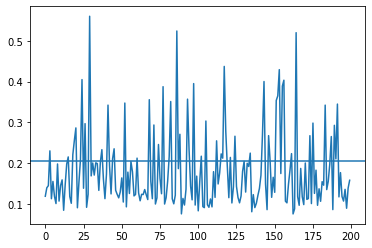

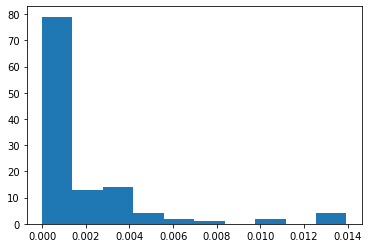

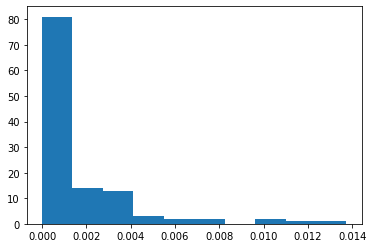

In [70]:
def sample_z():
  return 2*np.random.randint(0,2,(diag_H.shape[0]))-1

num_samples = 200
diag_H_approx = 0.
diag_H_sums = []
for _ in range(num_samples):
  z = sample_z()
  # grad(w+z)-grad(w) approx= H(w)z
  diag_H_i = z * (grad(X,y,w+z) - grad(X,y,w))
  diag_H_approx += diag_H_i / num_samples
  diag_H_sums.append(diag_H_i.sum())

plt.figure()
plt.plot(np.array(diag_H_sums))
plt.axhline(diag_H.sum())

plt.figure()
plt.hist(diag_H)
print(diag_H.sum())

plt.figure()
plt.hist(diag_H_approx)
print(diag_H_approx.sum())

## Run SARAH on badly-scaled data given the $diag(H)$ approximation

In [71]:
XTX = np.array((X.T @ X).todense())
XTX_bad = np.array((X_bad.T @ X_bad).todense())

PLotting singular values of X and X_bad


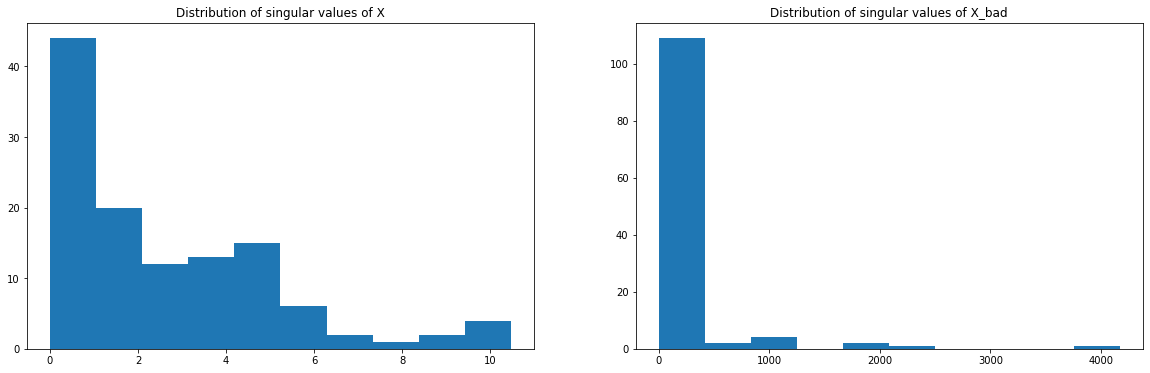

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 6)
ax1.set_title(r"Distribution of singular values of X")
ax1.hist(np.diagonal(XTX)**0.5)
ax2.set_title(r"Distribution of singular values of X_bad")
ax2.hist(np.diagonal(XTX_bad)**0.5)
print("PLotting singular values of X and X_bad")

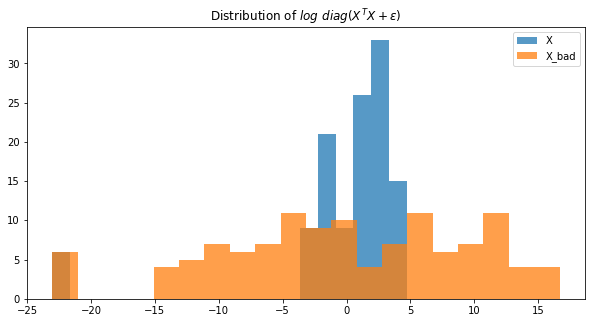

In [83]:
fig = plt.figure(figsize=(10,5))
plt.title(r"Distribution of $log\ diag(X^TX+\epsilon)$")
#plt.hist(np.diagonal(XTX_bad), label="bad X^TX")
#plt.hist(np.diagonal(XTX), label="X^TX")
plt.hist(np.log(np.diagonal(1e-10+XTX)), label="X", bins=20, alpha=0.75)
plt.hist(np.log(np.diagonal(1e-10+XTX_bad)), label="X_bad", bins=20, alpha=0.75)
plt.legend()

### SGD

Recall SGD on normal data with default settings
CPU times: user 8.45 s, sys: 27.6 ms, total: 8.48 s
Wall time: 8.49 s


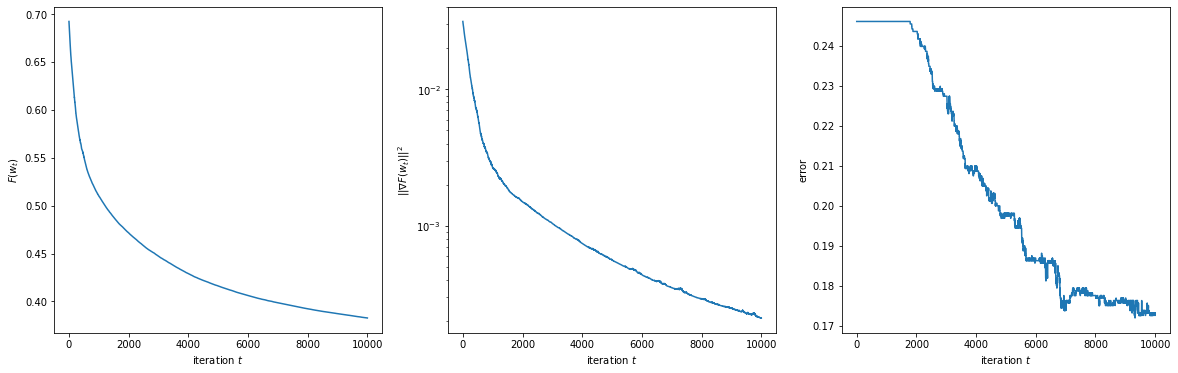

In [95]:
%%time
print("Recall SGD on normal data with default settings")
_, data = SGD(X,y,BS=10)
plot_data(data)

Run SGD on corrupted data
CPU times: user 8.4 s, sys: 34.6 ms, total: 8.43 s
Wall time: 8.43 s


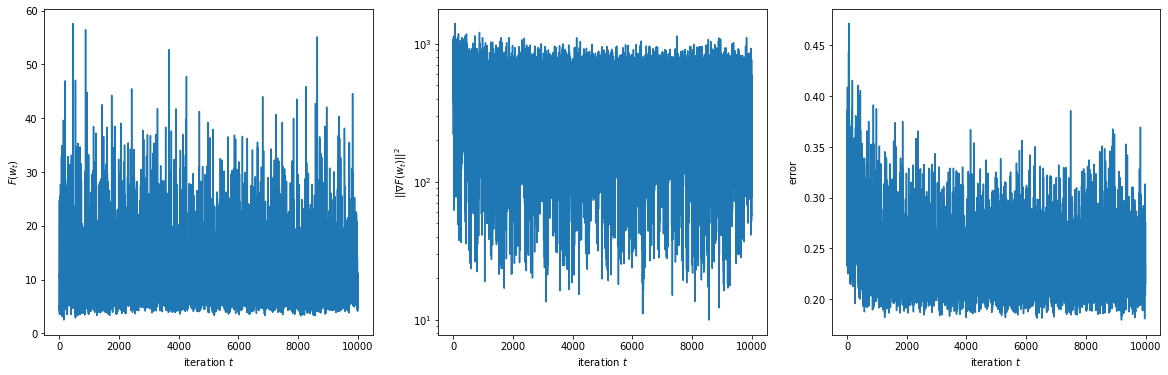

In [97]:
%%time
print("Run SGD on corrupted data")
_, data = SGD(X_bad,y,BS=10)
plot_data(data)

Now run SGD on corrupted data with diag(X_bad^TX_bad)^-0.5 scaling
CPU times: user 8.39 s, sys: 26.6 ms, total: 8.42 s
Wall time: 8.44 s


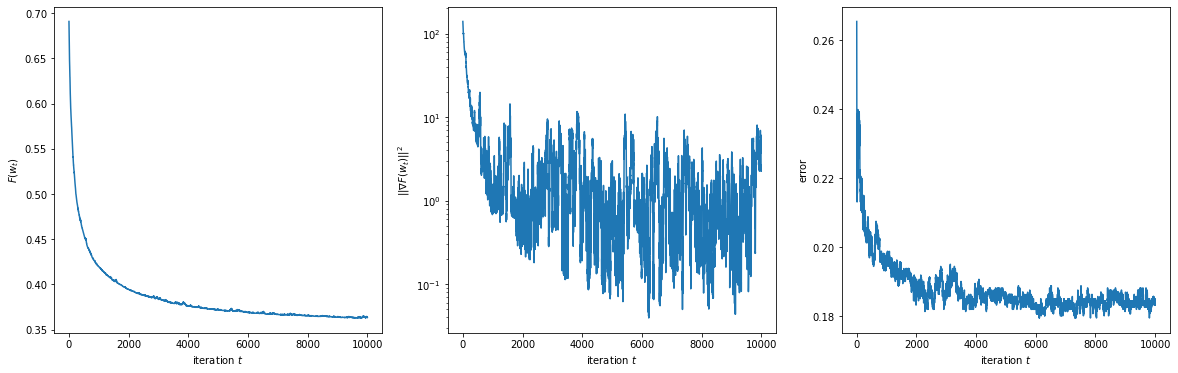

In [96]:
%%time
print("Now run SGD on corrupted data with diag(X_bad^TX_bad)^-0.5 scaling")
_, data = SGD(X_bad,y,BS=10,gamma=0.02*np.diagonal(XTX_bad+1e-10)**-0.5)
plot_data(data)

### SARAH

Recall SARAH on normal data with default settings
CPU times: user 17.2 s, sys: 59.8 ms, total: 17.3 s
Wall time: 17.3 s


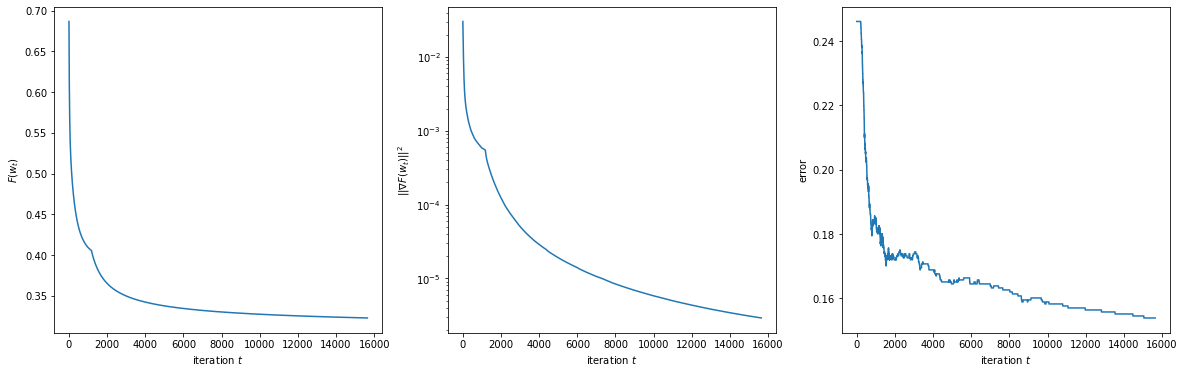

In [106]:
%%time
print("Recall SARAH on normal data with default settings")
_, data = SARAH(X,y)
plot_data(data)

Run SARAH on corrupted data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 17.9 s, sys: 58.9 ms, total: 18 s
Wall time: 18 s


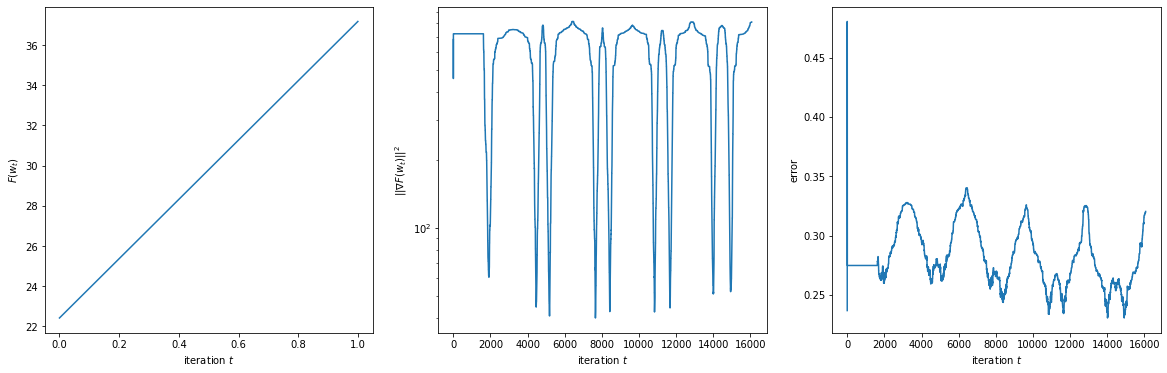

In [107]:
%%time
print("Run SARAH on corrupted data")
_, data = SARAH(X_bad,y)
plot_data(data)

Now run SARAH on corrupted data with diag(X_bad^TX_bad)^-0.5 scaling
CPU times: user 17.5 s, sys: 45.4 ms, total: 17.6 s
Wall time: 17.6 s


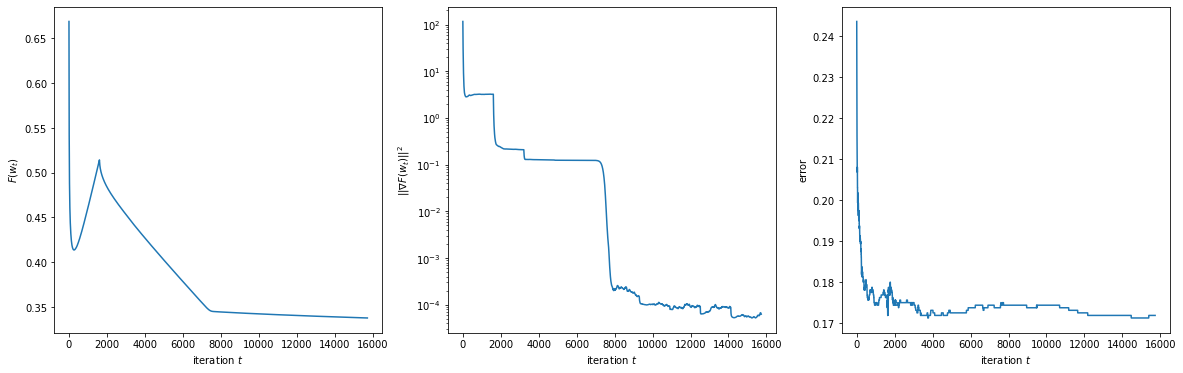

In [108]:
%%time
print("Now run SARAH on corrupted data with diag(X_bad^TX_bad)^-0.5 scaling")
_, data = SARAH(X_bad,y,BS=10,gamma=0.2*np.diagonal(XTX_bad+1e-10)**-0.5)
plot_data(data)

## Redefine SGD and SARAH with Hessian scaling

In [155]:
def SGD(X, y, gamma=0.02, BS=1, T=10000, seed=SEED, scale=None):
  np.random.seed(seed+1)
  data = []
  w = np.zeros(X.shape[1])
  def D(wi,i):
    if scale is None:
      return 1.
    elif scale == "hessian":
      return np.diagonal(hessian(X,y,wi,i)) + 1e-10
    elif scale == "hessian_approx":
      z = 2*np.random.randint(0,2,(wi.shape[0]))-1
      return z * (grad(X,y,wi+z,i) - grad(X,y,wi,i)) + 1e-10
    else:
      raise NotImplementedError(f"{scale} not implemented")

  for it in range(T):
    i = np.random.choice(X.shape[0], BS)
    w = w - gamma * D(w,i)**-1 * grad(X,y,w,i)
    data.append((F(X,y,w),
                  np.linalg.norm(grad(X,y,w))**2,
                  np.mean(X.dot(w)*y < 0)))
  return w, np.array(data)


def SARAH(X, y, gamma=0.2, BS=1, epochs=10, seed=SEED, scale=None):
  np.random.seed(seed+1)
  data = []
  wn = np.zeros(X.shape[1])
  def D(wi,i):
    if scale is None:
      return 1.
    elif scale == "hessian":
      return np.diagonal(hessian(X,y,wi,i)) + 1e-10
    elif scale == "hessian_approx":
      z = 2*np.random.randint(0,2,(wi.shape[0]))-1
      return z * (grad(X,y,w+z) - grad(X,y,w)) + 1e-10
    else:
      raise NotImplementedError(f"{scale} not implemented")

  for ep in range(epochs):
    v = grad(X,y,wn)
    nv0 = np.linalg.norm(v)
    wp = wn[:]
    for it in range(10**10):
      i = np.random.choice(X.shape[0], BS)
      gn = grad(X,y,wn,i)
      gp = grad(X,y,wp,i)
      v += gn - gp
      wp = wn[:]
      wn = wn - gamma * D(wn,i)**-1 * v
      data.append((F(X,y,wn),
                   np.linalg.norm(grad(X,y,wn))**2,
                   np.mean(X.dot(wn)*y < 0)))
      nv = np.linalg.norm(v)
      if nv < 0.1*nv0 or it > X.shape[0]:
        break
        
  return wn, np.array(data)

Now run SGD on corrupted data with hessian scaling
CPU times: user 12.9 s, sys: 32.5 ms, total: 12.9 s
Wall time: 12.9 s


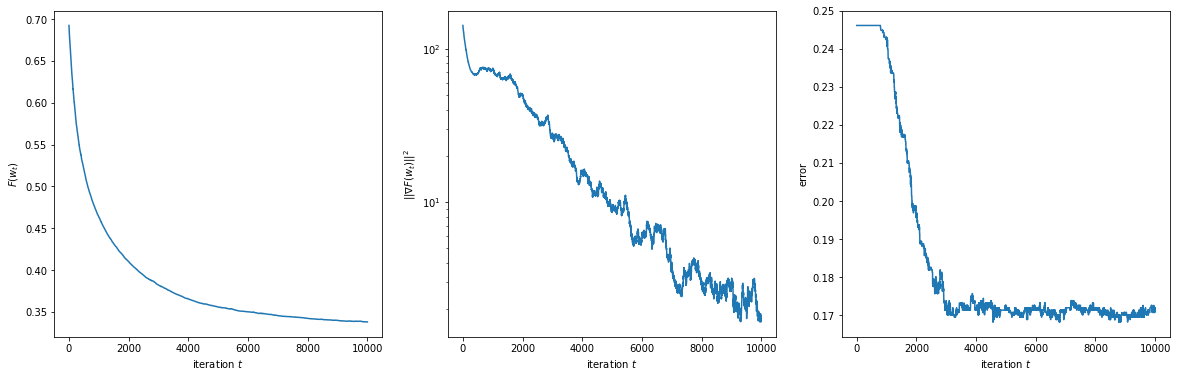

In [126]:
%%time
print("Now run SGD on corrupted data with hessian scaling")
_, data = SGD(X_bad,y,BS=10,gamma=2e-4,scale="hessian")
plot_data(data)

SARAH with hessian scaling
CPU times: user 24.4 s, sys: 65.9 ms, total: 24.5 s
Wall time: 24.5 s


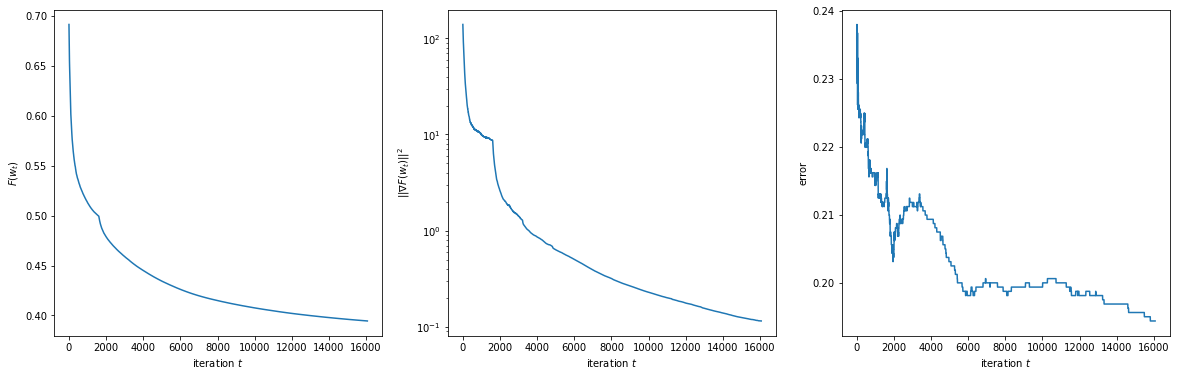

In [151]:
%%time
print("SARAH with hessian scaling")
_, data = SARAH(X_bad,y,gamma=2e-15,scale="hessian")
plot_data(data)

### Use approximate hessian for the scaling

SGD with approx hessian scaling


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 14.8 s, sys: 45.6 ms, total: 14.8 s
Wall time: 14.8 s


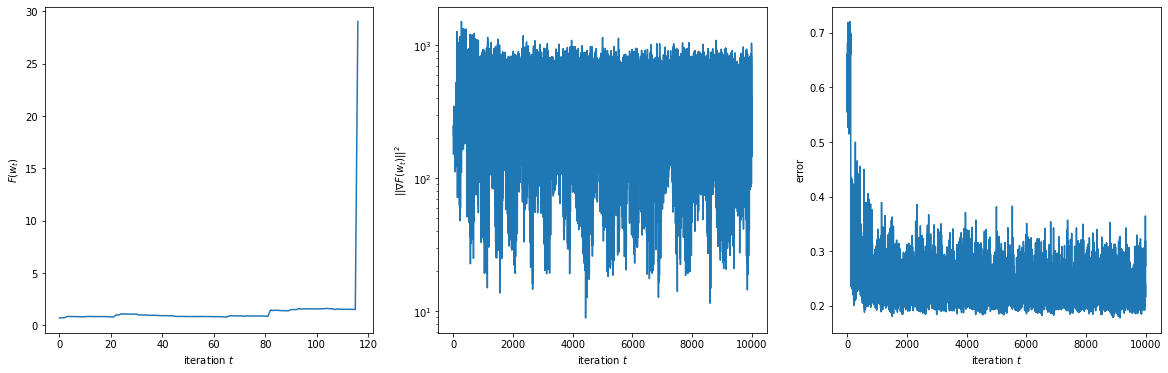

In [156]:
%%time
print("SGD with approx hessian scaling")
_, data = SGD(X_bad,y,BS=10,gamma=2e-4,scale="hessian_approx")
plot_data(data)

SARAH with approx hessian scaling
CPU times: user 29.5 s, sys: 58.5 ms, total: 29.5 s
Wall time: 29.6 s


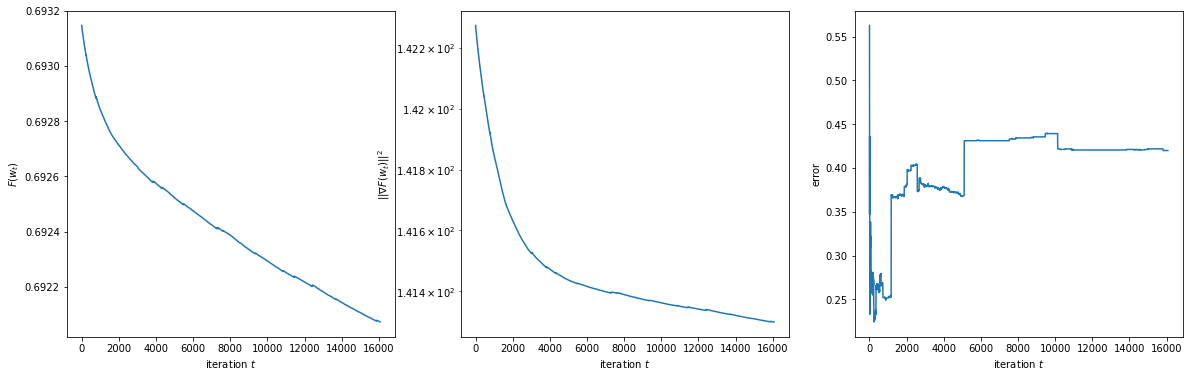

In [157]:
%%time
print("SARAH with approx hessian scaling")
_, data = SARAH(X_bad,y,BS=10,gamma=2e-15,scale="hessian_approx")
plot_data(data)

In [ ]:
#TODO: adaptive hessian approx